# Machine Learning for Medicine TP 4
## Feature Selection | Model Selection

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectFdr
from sklearn import linear_model

from sklearn.decomposition import PCA

### Datasets

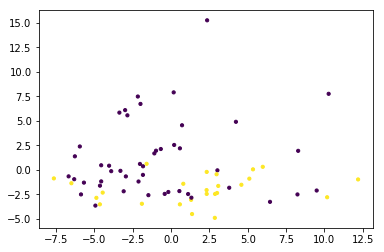

In [4]:
# Golub
X6 = pd.read_csv('data/Golub_X',sep=' ').values # Observations
Y6 = pd.read_csv('data/Golub_y',sep=' ')['0'] # Classes

X6_pca = PCA(n_components=2).fit_transform(X6)
plt.scatter(X6_pca[:, 0], X6_pca[:, 1], s=10, c=Y6)
plt.show()


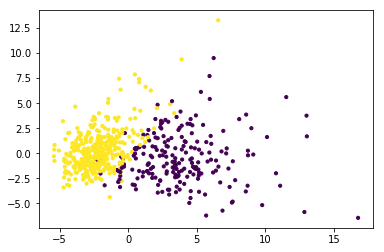

In [5]:
# Breast cancer
# X = pd.read_csv('data/wdbc.data',sep=',')
X = pd.read_csv('data/Breast.txt',sep=' ')
Y4 = X.values[:,30] # Classes
X4 = X.values[:,0:29] # Observations

X4_pca = PCA(n_components=2).fit_transform(X4)
plt.scatter(X4_pca[:, 0], X4_pca[:, 1], s=10, c=Y4)
plt.show()

### Functions

In [173]:
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



### On va tester les différentes séléctions de features avec la fonction définie ci-dessous.
### Elle retourne la moyenne des scores obtenus par un classifieur (ici RandomForestClassisfier ou SVC)
###  sur 20 plis du dataset donné en entrée.



# clf = RandomForestClassifier(n_estimators=10)
# clf = SVC(gamma='auto')
clf = linear_model.LinearRegression()

def score_kfolds(data, labels, folds=20, test_size=0.5, clf=clf):
    rs = ShuffleSplit(folds, test_size=test_size)
    scores = []
    for train_idx, test_idx in rs.split(data):
        x_train, y_train = data[train_idx], labels[train_idx]
        x_test,  y_test  = data[ test_idx], labels[ test_idx]
        sc_forest = clf.fit(x_train, y_train).score(x_test, y_test)
        scores.append(sc_forest)
    return np.mean(scores)
        

###  Experiments

In [174]:
## VarianceThreshold

Trs = VarianceThreshold

print(' - Dataset Breast Cancer - ')
data, labels = X4, Y4
st, me = data.std(axis=0).std(), np.median(data.std(axis=0))
print("std and median of std:\t", st, me)

t = np.percentile(data.std(axis=0), 50)
sel = Trs(threshold=t**2)
data_tr = sel.fit_transform(data)
print('before transform: {} features, after: {} features'.format(data.shape[1], data_tr.shape[1]))

s1 = score_kfolds(data, labels)
s2 = score_kfolds(data_tr, labels)
print('score before transform: {} , after: {}'.format(s1, s2))

########################


print('\n\n - Dataset Golub - ')
data, labels = X6, Y6
st, me = data.std(axis=0).std(), np.median(data.std(axis=0))
print("std and median of std:\t", st, me)

t = np.percentile(data.std(axis=0), 80)
sel = Trs(threshold=t**2)
data_tr = sel.fit_transform(data)
print('before transform: {} features, after: {} features'.format(data.shape[1], data_tr.shape[1]))

s1 = score_kfolds(data, labels)
s2 = score_kfolds(data_tr, labels)
print('score before transform: {} , after: {}'.format(s1, s2))




 - Dataset Breast Cancer - 
std and median of std:	 0.0024560756351101032 0.9964682780044686
before transform: 29 features, after: 14 features
score before transform: 0.6991128155142637 , after: 0.6946228569119636


 - Dataset Golub - 
std and median of std:	 0.029907669530615796 0.18795532191137274
before transform: 3562 features, after: 713 features
score before transform: 0.6351730485807521 , after: 0.6503397093135103


>> On n'observe pas vraiement d'amélioration entre les scores obtenus avec et sans feature selection par seuillage sur la variance.
On constate surtout que sur ces datasets, toutes les features ont des variances relativement similaires: les variances des variances sont respectivement de 0.002 et 0.03 pour Breast et Golub. 
Il est difficile sur ces datasets de distinguer les features seulement sur la base de leurs variances.

In [169]:
#Univariate

print(' - Dataset Breast Cancer - ')
data, labels = X4, Y4

sel = SelectFdr()
data_tr = sel.fit_transform(data, labels)
print('before transform: {} features, after: {} features'.format(data.shape[1], data_tr.shape[1]))

s1 = score_kfolds(data, labels)
s2 = score_kfolds(data_tr, labels)
print('score before transform: {} , after: {}'.format(s1, s2))

########################


print('\n\n - Dataset Golub - ')
data, labels = X6, Y6

sel = SelectFdr()
data_tr = sel.fit_transform(data, labels)
print('before transform: {} features, after: {} features'.format(data.shape[1], data_tr.shape[1]))

s1 = score_kfolds(data, labels)
s2 = score_kfolds(data_tr, labels)
print('score before transform: {} , after: {}'.format(s1, s2))




 - Dataset Breast Cancer - 
before transform: 29 features, after: 24 features
score before transform: 0.71015636613619 , after: 0.7224636053573856


 - Dataset Golub - 
before transform: 3562 features, after: 544 features
score before transform: 0.5970474601012459 , after: 0.8164507723054081


>> Avec le module `SelectFdr`, on constate une très légère amélioration sur le dataset Breast cancer mais une très significante sur Golub.

In [217]:
# Logistic regression

alpha = .05
cls_noreg = linear_model.LinearRegression() #linear_model.Lasso(alpha=0)
cls = linear_model.Lasso(alpha=alpha)

print(' - Dataset Breast Cancer - ')
data, labels = X4, Y4

s1 = score_kfolds(data, labels, clf=cls_noreg)
s2 = score_kfolds(data, labels, clf=cls)
print('without regularisation: {} features, after: {} features'.format((cls_noreg.coef_!=0).sum(), (cls.coef_!=0).sum()))
print('score without regularisation: {} , after: {}'.format(s1, s2))

########################


alpha = .0005
cls_noreg = linear_model.LinearRegression()
cls = linear_model.Lasso(alpha=alpha, max_iter=5000)

print('\n\n - Dataset Golub - ')
data, labels = X6, Y6

s1 = score_kfolds(data, labels, clf=cls_noreg)
s2 = score_kfolds(data, labels, clf=cls)
print('without regularisation: {} features, after: {} features'.format((cls_noreg.coef_!=0).sum(), (cls.coef_!=0).sum()))
print('score without regularisation: {} , after: {}'.format(s1, s2))



 - Dataset Breast Cancer - 
without regularisation: 29 features, after: 7 features
score without regularisation: 0.7052615547365221 , after: 0.7075439212500533


 - Dataset Golub - 
without regularisation: 3562 features, after: 35 features
score without regularisation: 0.599801746905341 , after: 0.6610919972435234


>> We don't observe any imporvement on the Breast cancer dataset with en L1 penalty, but there is one on the Golub dataset.

In [211]:
# SVM

C = .1
cls = LinearSVC(C=C, penalty="l1", dual=False)

print(' - Dataset Breast Cancer - ')
data, labels = X4, Y4

s2 = score_kfolds(data, labels, clf=cls)
print('before transform: {} features, after: {} features'.format(data.shape[1], (cls.coef_!=0).sum()))
print('score {}'.format(s2))

########################


C = 1
cls = LinearSVC(C=C, penalty="l1", dual=False, max_iter=5000)

print('\n\n - Dataset Golub - ')
data, labels = X6, Y6

# s1 = score_kfolds(data, labels, clf=cls_noreg)
s2 = score_kfolds(data, labels, clf=cls)
print('before transform: {} features, after: {} features'.format(data.shape[1], (cls.coef_!=0).sum()))
print('score : {}'.format(s1, s2))


 - Dataset Breast Cancer - 
before transform: 29 features, after: 10 features
score 0.9711267605633804


 - Dataset Golub - 
before transform: 3562 features, after: 19 features
score : 0.6508327231554717


In [216]:
# Elastic net



alpha = .001
cls_noreg = linear_model.LinearRegression() 
cls = ElasticNet(alpha=alpha, l1_ratio=.7, max_iter=5000)

print(' - Dataset Breast Cancer - ')
data, labels = X4, Y4

s1 = score_kfolds(data, labels, clf=cls_noreg)
s2 = score_kfolds(data, labels, clf=cls)
print('without regularisation: {} features, after: {} features'.format((cls_noreg.coef_!=0).sum(), (cls.coef_!=0).sum()))
print('score without regularisation: {} , after: {}'.format(s1, s2))

########################


alpha = .0005
cls_noreg = linear_model.LinearRegression()
cls = ElasticNet(alpha=alpha, l1_ratio=.7, max_iter=5000)

print('\n\n - Dataset Golub - ')
data, labels = X6, Y6

s1 = score_kfolds(data, labels, clf=cls_noreg)
s2 = score_kfolds(data, labels, clf=cls)
print('without regularisation: {} features, after: {} features'.format((cls_noreg.coef_!=0).sum(), (cls.coef_!=0).sum()))
print('score without regularisation: {} , after: {}'.format(s1, s2))




 - Dataset Breast Cancer - 
without regularisation: 29 features, after: 26 features
score without regularisation: 0.7088231379799812 , after: 0.7272542218984495


 - Dataset Golub - 
without regularisation: 3562 features, after: 38 features
score without regularisation: 0.646248051131778 , after: 0.7187416157393901


>> Au final on constate que sur le dataset Breast cancer, les SVM linaires obtiennent de loin le meilleur score avec un tier des features originales.

>> Sur le dataset Golub, c'est la séléction sur la base des p-values qui permet d'obtenir le meilleur score, en gardant environ 500 features sur les 3562. 
Le second meilleur est `ElasticNet` avec seulement 38 features.